# Zimp Vocabulary Size Evaluation
How many different words? How frequent are they?

In [1]:
import pandas as pd
import numpy as np
import os
import logging
import matplotlib.pyplot as plt
import time
from zimp.pos.countvectorizer_analyzer import CountVectorizerAnalyzer
from glob import glob

plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [2]:
source_dir = '../../zimp_orchestrator/orch/resources'
files = {}

In [3]:
for ds_path in glob(source_dir + '/*'):
    if not os.path.isdir(ds_path):
        continue
    ds_name = os.path.basename(ds_path)
    files[ds_name] = [os.path.join(ds_path, 'train.csv'), os.path.join(ds_path, 'test.csv')]

In [4]:
def get_ds_stats(paths, cva_builder, track_name):
    texts = pd.read_csv(paths[0]).text.append(pd.read_csv(paths[1]).text)
    return cva_builder(texts).extract_dataset_metric().rename(columns={'count': track_name})

def get_ds_language(track):
    if track in ['10K-GNAD', 'GERMEVAL-2018', 'GERMEVAL-2020']:
        return 'german'
    return 'english'

In [5]:
file_path = 'measures/vocab_size_<DS>.csv'
results_dfs = {}
for dataset in files:
    dataset_path = file_path.replace('<DS>', dataset)
    if os.path.exists(dataset_path):
        df_dataset = pd.read_csv(dataset_path, index_col=0)
        print('Loaded existing stats for', dataset)
    else:
        df_dataset = get_ds_stats(files[dataset], lambda texts: CountVectorizerAnalyzer(texts, language=get_ds_language(dataset)), 'count')
        df_dataset.to_csv(dataset_path)
        print('Calculated stats for', dataset)
        
    results_dfs[dataset] = df_dataset

results_dfs['TREC-6'].head(n=5)

Loaded existing stats for 10K-GNAD
Loaded existing stats for DBP-14
Loaded existing stats for GERMEVAL-2018
Loaded existing stats for GERMEVAL-2020
Loaded existing stats for TREC-6
Loaded existing stats for YELP-5


,count
?,5850
the,4066
what,3726
is,1970
of,1641


In [6]:
def get_vocab_stats(df_vocab):
    df_cumrat = df_vocab.cumsum()/df_vocab.sum()
    return {
        'vocab_size': df_vocab.index.size,
        'min_2_occ': (df_vocab > 1).sum().get('count'),
        'min_3_occ': (df_vocab > 2).sum().get('count'),
        'min_5_occ': (df_vocab > 4).sum().get('count'),
        'vocab_5_percent': (df_cumrat < 0.05).sum().get('count') + 1,
        'vocab_10_percent': (df_cumrat < 0.1).sum().get('count') + 1,
        'vocab_25_percent': (df_cumrat < 0.25).sum().get('count') + 1,
        'vocab_50_percent': (df_cumrat < 0.5).sum().get('count') + 1,
        'vocab_top10': df_cumrat.iloc[9, 0],
        'vocab_top100': df_cumrat.iloc[99, 0],
        'vocab_top300': df_cumrat.iloc[299, 0],
        'vocab_top500': df_cumrat.iloc[499, 0],
    }

In [7]:
file_path = 'measures/vocab_stats.csv'
if os.path.exists(file_path):
    df_vocab = pd.read_csv(file_path, index_col=0)
else:
    vocab_series = []
    for dataset in results_dfs:
        vocab_series.append(pd.Series(get_vocab_stats(results_dfs[dataset]), name=dataset))
    df_vocab = pd.DataFrame(vocab_series)
    df_vocab.to_csv(file_path)
    
df_vocab

,vocab_size,min_2_occ,min_3_occ,min_5_occ,vocab_5_percent,vocab_10_percent,vocab_25_percent,vocab_50_percent,vocab_top10,vocab_top100,vocab_top300,vocab_top500
10K-GNAD,227275.0,99285.0,67546.0,43569.0,1.0,2.0,13.0,125.0,0.230348,0.480994,0.569957,0.610090
DBP-14,967723.0,493036.0,282784.0,166010.0,1.0,3.0,9.0,148.0,0.279432,0.469249,0.562971,0.612887
GERMEVAL-2018,25822.0,9643.0,6102.0,3579.0,1.0,2.0,11.0,89.0,0.243331,0.514432,0.626194,0.674467
GERMEVAL-2020,217703.0,54480.0,33770.0,20778.0,1.0,2.0,6.0,43.0,0.324037,0.594837,0.711502,0.759534
TREC-6,8965.0,3638.0,2277.0,1277.0,1.0,2.0,4.0,30.0,0.370228,0.595349,0.680120,0.722379
YELP-5,768397.0,236568.0,157574.0,104285.0,2.0,3.0,10.0,62.0,0.262256,0.569781,0.705211,0.765781


In [8]:
def get_latex_dataset(dataset):
    return {
        '10K-GNAD': '10kGNAD',
        'DBP-14': 'DBP-14',
        'GERMEVAL-2018': 'GermEval2018',
        'GERMEVAL-2020': 'GermEval2020',
        'TREC-6': 'Trec-6',
        'YELP-5': 'Yelp-5'
    }.get(dataset)

In [9]:
print("""
\\begin{table}[]
    \centering
    \\begin{tabular}{l|c|c|c|c|c|c}
        Dataset & $V$ & $V_5$ & $v(i)=0.5$ & $v(10)$ & $v(100)$ & $v(300)$ \\\\ \hline""")

for idx, row in df_vocab.iterrows():
    print('\t'*2,
          '\\texttt{'+get_latex_dataset(idx)+ '}',
          f"& {int(row.vocab_size)} & {int(row.min_5_occ)} & {int(row.vocab_50_percent)}",
          f"& {row.vocab_top10:.2f} & {row.vocab_top100:.2f} & {row.vocab_top300:.2f}",
          "\\\\")

print("""    \end{tabular}
\end{table}
""")


\begin{table}[]
    \centering
    \begin{tabular}{l|c|c|c|c|c|c}
        Dataset & $V$ & $V_5$ & $v(i)=0.5$ & $v(10)$ & $v(100)$ & $v(300)$ \\ \hline
		 \texttt{10kGNAD} & 227275 & 43569 & 125 & 0.23 & 0.48 & 0.57 \\
		 \texttt{DBP-14} & 967723 & 166010 & 148 & 0.28 & 0.47 & 0.56 \\
		 \texttt{GermEval2018} & 25822 & 3579 & 89 & 0.24 & 0.51 & 0.63 \\
		 \texttt{GermEval2020} & 217703 & 20778 & 43 & 0.32 & 0.59 & 0.71 \\
		 \texttt{Trec-6} & 8965 & 1277 & 30 & 0.37 & 0.60 & 0.68 \\
		 \texttt{Yelp-5} & 768397 & 104285 & 62 & 0.26 & 0.57 & 0.71 \\
    \end{tabular}
\end{table}



In [10]:
df_vocab.min_5_occ / df_vocab.vocab_size

10K-GNAD         0.191702
DBP-14           0.171547
GERMEVAL-2018    0.138603
GERMEVAL-2020    0.095442
TREC-6           0.142443
YELP-5           0.135718
dtype: float64

## Zipfs Law

(1, 10000000)

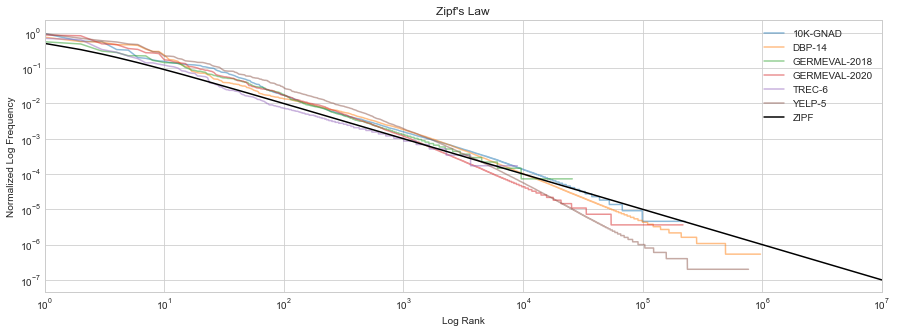

In [79]:
fig = plt.figure(figsize=(15,5))
ax = ax = fig.add_subplot(1, 1, 1)

def plot_zipf(df, ax):
    df = df.reset_index(drop=True)
    
    (df['count']/df['count'].max()).plot(ax=ax, logx=True,logy=True, alpha=.5)
    return df

for df in results_dfs:
    plot_zipf(results_dfs[df], ax)

pd.Series([1/x for x in range(1,10**7)]).plot(ax=ax, logx=True, logy=True, color='black')
    
ax.set_title("Zipf's Law")
ax.set_xlabel("Log Rank")
ax.set_ylabel('Normalized Log Frequency')
ax.legend(list(results_dfs.keys()) + ['ZIPF'])
ax.set_xlim([1,10**7])

In [85]:
d = results_dfs['TREC-6'].reset_index(drop=True)
((d.index+1) * d['count']).describe()

count     8965.000000
mean      6047.814055
std       1307.192465
min       3639.000000
25%       5070.000000
50%       5856.000000
75%       6923.000000
max      11178.000000
dtype: float64